In [56]:
# 1. IMPORT LIBRARIES & SETTINGS

!pip install ydata-profiling

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import math

# For stats-based steps
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# For feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# For oversampling/undersampling
from imblearn.over_sampling import SMOTE

# For data splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,RocCurveDisplay, classification_report
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error , mean_squared_error , accuracy_score
from mlxtend.plotting import plot_confusion_matrix

# For classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# For scaling
from sklearn.preprocessing import StandardScaler

# For confusion matrix visualization
from mlxtend.plotting import plot_confusion_matrix

# For advanced Bayesian hyperparameter tuning
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical



In [57]:
data = pd.read_csv("/content/diabetes_binary_health_indicators_BRFSS2015.csv")

In [58]:
profile = ProfileReport(data)

In [59]:
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
print("DATA SHAPE:", data.shape)

DATA SHAPE: (253680, 22)


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

The data type is float64, I will convert the data type into lower space of int8 for 15 variables that have binary value, 6 variables with integer to int8, and int16 for income variable

In [62]:
# Convert appropriate columns to smaller integer types for memory efficiency
binary_cols = [
    "Diabetes_binary","HighBP","HighChol","CholCheck","Smoker","Stroke",
    "HeartDiseaseorAttack","PhysActivity","Fruits","Veggies","HvyAlcoholConsump",
    "AnyHealthcare","NoDocbcCost","DiffWalk","Sex"
]
for col in binary_cols:
    data[col] = data[col].astype("int8")

# The second part
int_cols = ["BMI","GenHlth","MentHlth","PhysHlth","Age","Education"]
for col in int_cols:
    data[col] = data[col].astype("int8")

data["Income"] = data["Income"].astype("int32")

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_binary       253680 non-null  int8 
 1   HighBP                253680 non-null  int8 
 2   HighChol              253680 non-null  int8 
 3   CholCheck             253680 non-null  int8 
 4   BMI                   253680 non-null  int8 
 5   Smoker                253680 non-null  int8 
 6   Stroke                253680 non-null  int8 
 7   HeartDiseaseorAttack  253680 non-null  int8 
 8   PhysActivity          253680 non-null  int8 
 9   Fruits                253680 non-null  int8 
 10  Veggies               253680 non-null  int8 
 11  HvyAlcoholConsump     253680 non-null  int8 
 12  AnyHealthcare         253680 non-null  int8 
 13  NoDocbcCost           253680 non-null  int8 
 14  GenHlth               253680 non-null  int8 
 15  MentHlth              253680 non-n

We Successfuly decrese the memory usage by 6 times

In [64]:
# Check duplicate rows
duplicates_count = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")


Number of duplicate rows: 24206


Drop the duplicate data rows

In [65]:
data.drop_duplicates(inplace = True)

In [66]:
print("DATA SHAPE AFTER DROPPING DUPLICATES:", data.shape)

DATA SHAPE AFTER DROPPING DUPLICATES: (229474, 22)


In [67]:
# Check missing columns

missing_count = data.isnull().sum().sum()
print(f"\nTotal missing values in the dataset: {missing_count}")


Total missing values in the dataset: 0


# Exploratory Data Analysis


In [68]:
# After perform basic checking of the data, let's see some part of it. Also to make sure that the bit range we change earlier can fit

data.head()

Diabetes_binary  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0                0       1         1          1   40       1       0   
1                0       0         0          0   25       1       0   
2                0       1         1          1   28       0       0   
3                0       1         0          1   27       0       0   
4                0       1         1          1   24       0       0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                     0             0       0  ...              1   
1                     0             1       0  ...              0   
2                     0             0       1  ...              1   
3                     0             1       1  ...              1   
4                     0             1       1  ...              1   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  \
0            0        5        18        15         1    0    9          4   
1            1        3         0         0         0    0    7          6   
2            1        5        30        30         1    0    9          4   
3            0        2         0         0         0    0   11          3   
4            0        2         3         0         0    0   11          5   

   Income  
0       3  
1       1  
2       8  
3       6  
4       4  

[5 rows x 22 columns]

In [107]:
unique_values = {}
for col in data.columns:
    unique_values[col] = data[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count'])

Diabetes_binary  HighBP  HighChol  CholCheck  BMI  Smoker  \
unique value count                2       2         2          2   84       2   

                    Stroke  HeartDiseaseorAttack  PhysActivity  Fruits  ...  \
unique value count       2                     2             2       2  ...   

                    Education  Income  Lifestyle_Score  Access_to_Care_Score  \
unique value count          6       8                6                     3   

                    General_Health_Index  Cardiovascular_Risk  \
unique value count                   313                    5   

                    Socioeconomic_Status   PC1   PC2  Cluster  
unique value count                    47  3748  3748        2  

[1 rows x 30 columns]

In [70]:
#Function to view the value counts for the whole data

def v_counts(dataframe):
    for i in dataframe :
        print(dataframe[i].value_counts())
        print("_____________________________________________________________________________")

v_counts(data)

Diabetes_binary
0    194377
1     35097
Name: count, dtype: int64
_____________________________________________________________________________
HighBP
0    125214
1    104260
Name: count, dtype: int64
_____________________________________________________________________________
HighChol
0    128129
1    101345
Name: count, dtype: int64
_____________________________________________________________________________
CholCheck
1    220176
0      9298
Name: count, dtype: int64
_____________________________________________________________________________
BMI
27    21514
26    17775
24    16497
28    14914
25    14793
      ...  
85        1
91        1
86        1
90        1
78        1
Name: count, Length: 84, dtype: int64
_____________________________________________________________________________
Smoker
0    122585
1    106889
Name: count, dtype: int64
_____________________________________________________________________________
Stroke
0    219190
1     10284
Name: count, dtype: int64
__

<ipython-input-71-7ee167edbcae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, data = data ,palette='Set2')
<ipython-input-71-7ee167edbcae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, data = data ,palette='Set2')
<ipython-input-71-7ee167edbcae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, data = data ,palette='Set2')
<ipython-input-71-7ee167edbcae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=F

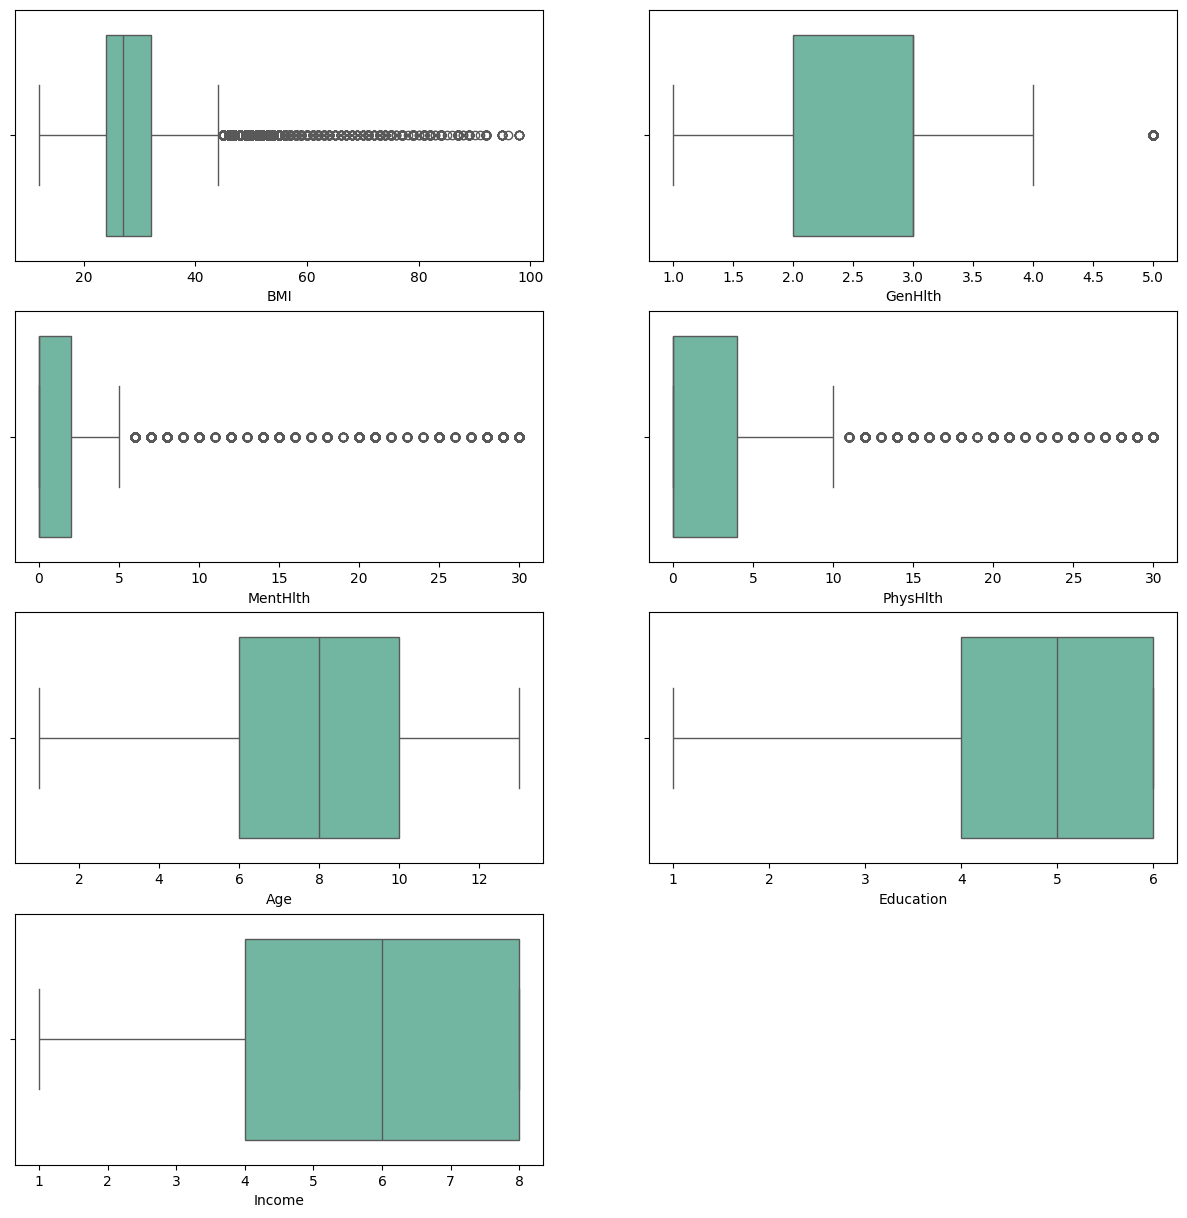

In [71]:
plt.figure(figsize = (15,15))
for i,col in enumerate(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age','Education', 'Income']):
    plt.subplot(4,2,i+1)
    sns.boxplot(x = col, data = data ,palette='Set3')
plt.show()

In [72]:
data2 = data.copy()

In [73]:
# Show the relation between features in better form

data2.Age[data2['Age'] == 1] = '18 to 24'
data2.Age[data2['Age'] == 2] = '25 to 29'
data2.Age[data2['Age'] == 3] = '30 to 34'
data2.Age[data2['Age'] == 4] = '35 to 39'
data2.Age[data2['Age'] == 5] = '40 to 44'
data2.Age[data2['Age'] == 6] = '45 to 49'
data2.Age[data2['Age'] == 7] = '50 to 54'
data2.Age[data2['Age'] == 8] = '55 to 59'
data2.Age[data2['Age'] == 9] = '60 to 64'
data2.Age[data2['Age'] == 10] = '65 to 69'
data2.Age[data2['Age'] == 11] = '70 to 74'
data2.Age[data2['Age'] == 12] = '75 to 79'
data2.Age[data2['Age'] == 13] = '80 or older'

data2.Diabetes_binary[data2['Diabetes_binary'] == 0] = 'No Diabetes'
data2.Diabetes_binary[data2['Diabetes_binary'] == 1] = 'Diabetes'

data2.HighBP[data2['HighBP'] == 0] = 'No High'
data2.HighBP[data2['HighBP'] == 1] = 'High BP'

data2.HighChol[data2['HighChol'] == 0] = 'No High Cholesterol'
data2.HighChol[data2['HighChol'] == 1] = 'High Cholesterol'

data2.CholCheck[data2['CholCheck'] == 0] = 'No Cholesterol Check in 5 Years'
data2.CholCheck[data2['CholCheck'] == 1] = 'Cholesterol Check in 5 Years'

data2.Smoker[data2['Smoker'] == 0] = 'No'
data2.Smoker[data2['Smoker'] == 1] = 'Yes'

data2.Stroke[data2['Stroke'] == 0] = 'No'
data2.Stroke[data2['Stroke'] == 1] = 'Yes'

data2.HeartDiseaseorAttack[data2['HeartDiseaseorAttack'] == 0] = 'No'
data2.HeartDiseaseorAttack[data2['HeartDiseaseorAttack'] == 1] = 'Yes'

data2.PhysActivity[data2['PhysActivity'] == 0] = 'No'
data2.PhysActivity[data2['PhysActivity'] == 1] = 'Yes'

data2.Fruits[data2['Fruits'] == 0] = 'No'
data2.Fruits[data2['Fruits'] == 1] = 'Yes'

data2.Veggies[data2['Veggies'] == 0] = 'No'
data2.Veggies[data2['Veggies'] == 1] = 'Yes'

data2.HvyAlcoholConsump[data2['HvyAlcoholConsump'] == 0] = 'No'
data2.HvyAlcoholConsump[data2['HvyAlcoholConsump'] == 1] = 'Yes'

data2.AnyHealthcare[data2['AnyHealthcare'] == 0] = 'No'
data2.AnyHealthcare[data2['AnyHealthcare'] == 1] = 'Yes'

data2.NoDocbcCost[data2['NoDocbcCost'] == 0] = 'No'
data2.NoDocbcCost[data2['NoDocbcCost'] == 1] = 'Yes'

data2.GenHlth[data2['GenHlth'] == 5] = 'Excellent'
data2.GenHlth[data2['GenHlth'] == 4] = 'Very Good'
data2.GenHlth[data2['GenHlth'] == 3] = 'Good'
data2.GenHlth[data2['GenHlth'] == 2] = 'Fair'
data2.GenHlth[data2['GenHlth'] == 1] = 'Poor'

data2.DiffWalk[data2['DiffWalk'] == 0] = 'No'
data2.DiffWalk[data2['DiffWalk'] == 1] = 'Yes'

data2.Sex[data2['Sex'] == 0] = 'Female'
data2.Sex[data2['Sex'] == 1] = 'Male'

data2.Education[data2['Education'] == 1] = 'Never Attended School'
data2.Education[data2['Education'] == 2] = 'Elementary'
data2.Education[data2['Education'] == 3] = 'Junior High School'
data2.Education[data2['Education'] == 4] = 'Senior High School'
data2.Education[data2['Education'] == 5] = 'Undergraduate Degree'
data2.Education[data2['Education'] == 6] = 'Magister'

data2.Income[data2['Income'] == 1] = 'Less Than $10,000'
data2.Income[data2['Income'] == 2] = 'Less Than $10,000'
data2.Income[data2['Income'] == 3] = 'Less Than $10,000'
data2.Income[data2['Income'] == 4] = 'Less Than $10,000'
data2.Income[data2['Income'] == 5] = 'Less Than $35,000'
data2.Income[data2['Income'] == 6] = 'Less Than $35,000'
data2.Income[data2['Income'] == 7] = 'Less Than $35,000'
data2.Income[data2['Income'] == 8] = '$75,000 or More'

<ipython-input-73-3e6bf947602e>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data2.Age[data2['Age'] == 1] = '18 to 24'
<ipython-input-73-3e6bf947602e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

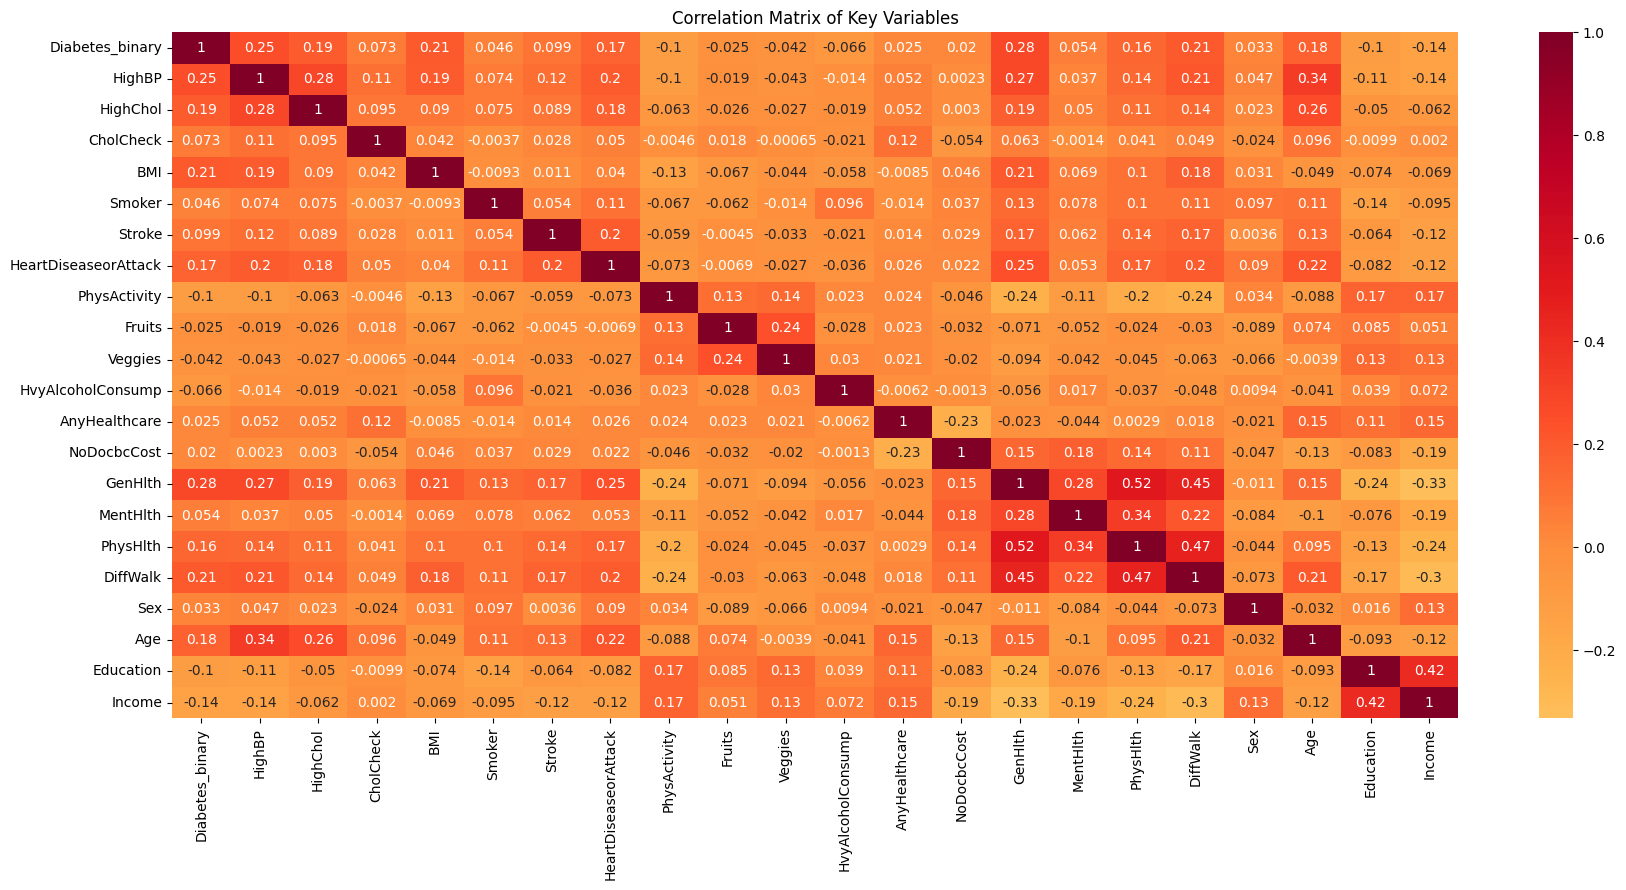

In [74]:
# Use heatmap to understand correlation better in dataset data

corr_matrix = data.corr()

plt.figure(figsize=(18,9))
# Use a diverging palette that highlights negative vs. positive correlations
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd', center=0)
plt.title("Correlation Matrix of Key Variables", fontsize=12)
plt.tight_layout()
plt.show()

Correlation heatmap show relation between columns:

- (GenHlth ,PhysHlth ),(PhysHlth , DiffWalk),(GenHlth ,DiffWalk )are highly correleted with each other => positive relation

- (GenHlth ,Income ) , (DiffWalk , Income) are highly correleted with each other => Nagative relation



In [75]:
 # Check VIF to make sure no Multicollinearity
def calc_VIF(x):
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif = vif.sort_values(by="VIF", ascending=False)

    return vif

X = add_constant(data)

ds = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).sort_values(ascending=False)

print(ds)

const                   109.425291
GenHlth                   1.741508
PhysHlth                  1.594308
DiffWalk                  1.513943
Income                    1.431806
Age                       1.359039
HighBP                    1.315161
Education                 1.272148
MentHlth                  1.221789
Diabetes_binary           1.182154
HeartDiseaseorAttack      1.170400
HighChol                  1.166374
BMI                       1.141796
NoDocbcCost               1.135686
PhysActivity              1.130550
AnyHealthcare             1.109935
Veggies                   1.098136
Fruits                    1.097950
Stroke                    1.077944
Sex                       1.076736
Smoker                    1.076125
CholCheck                 1.035970
HvyAlcoholConsump         1.027834
dtype: float64


All VIF value is < 5, indicating no multicolinearity

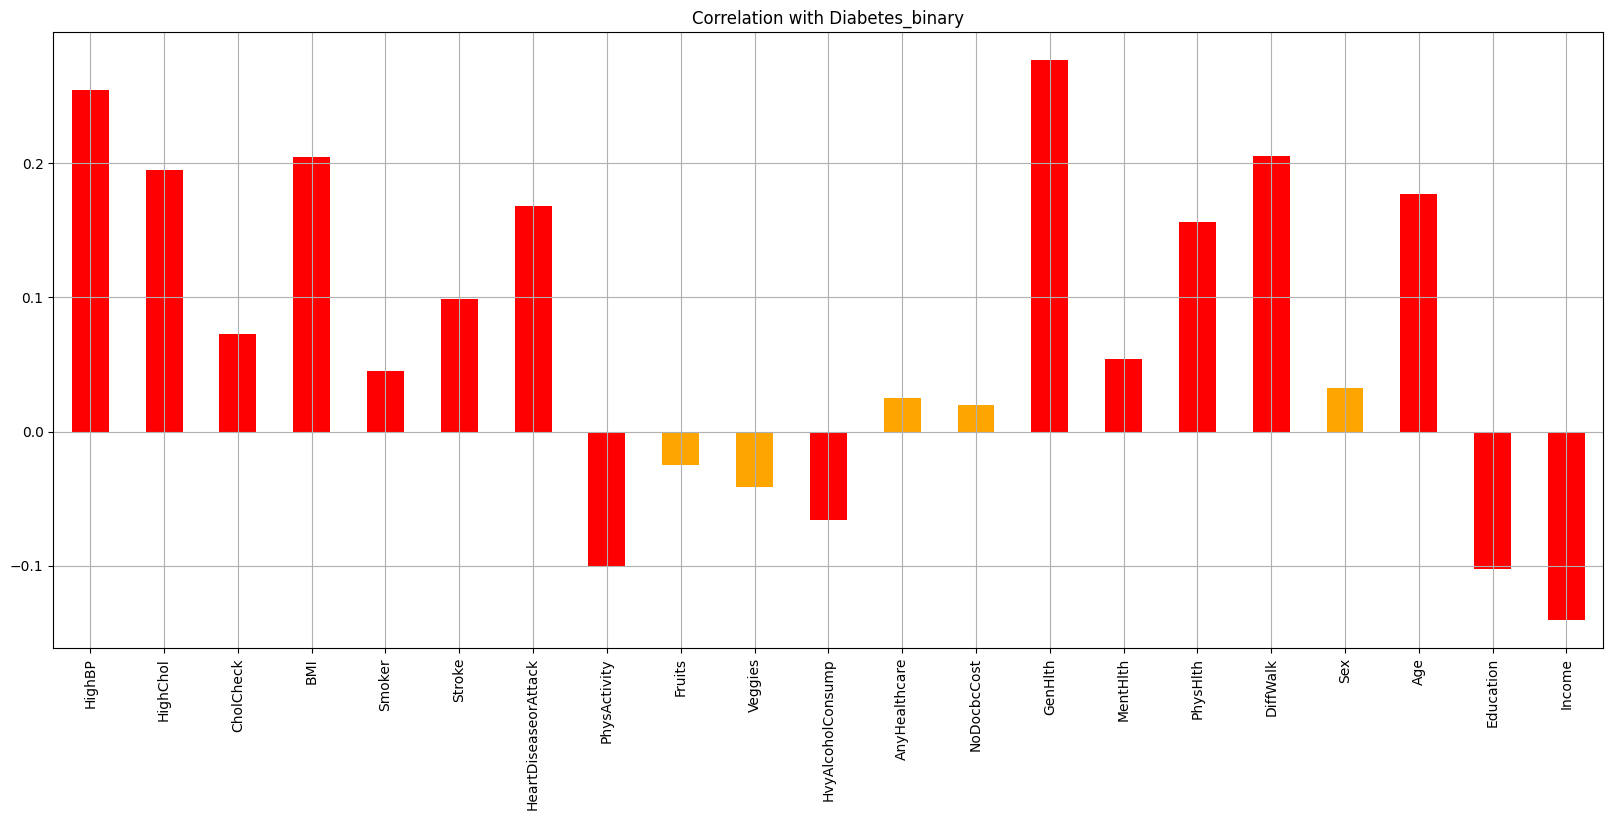

In [76]:
correlations = data.drop('Diabetes_binary', axis=1).corrwith(data.Diabetes_binary)

# Get the indices of the 5 lowest absolute correlation values
lowest_5_indices = correlations.abs().nsmallest(5).index

# Assign colors: use 'red' for the lowest 5 and 'purple' for the rest
colors = ['orange' if col in lowest_5_indices else 'red' for col in correlations.index]

# Plot the correlation values
correlations.plot(kind='bar', grid=True, figsize=(20, 8), title="Correlation with Diabetes_binary", color=colors)

plt.show()

**Diabetes_binary's relation with other columns:**

Fruits , AnyHealthcare , NoDocbccost and sex are least correlated with Diabetes_binary.

HighBP , HighChol , BMI , smoker , stroke , HeartDiseaseorAttack , PhysActivity , Veggies , MentHlth , HvyAlcoholconsump , GenHlth , PhysHlth , Age , Education , Income and DiffWalk have a significant correlation with Diabetes_binary.

In [77]:
X = data.iloc[:,1:]
Y = data.iloc[:,0]

In [78]:
# Potential "Lifestyle_Score" concept
data["Lifestyle_Score"] = (
    data["PhysActivity"] + data["Fruits"] + data["Veggies"]
    - data["Smoker"] - data["HvyAlcoholConsump"]
)

# Potential "Access_to_Care_Score"
data["Access_to_Care_Score"] = data["AnyHealthcare"] - data["NoDocbcCost"]

# Potential "General_Health_Index"
data["General_Health_Index"] = (
    (6 - data["GenHlth"]) +
    (30 - data["MentHlth"])/30 +
    (30 - data["PhysHlth"])/30
)

# Potential "Cardiovascular_Risk"
data["Cardiovascular_Risk"] = (
    data["HighBP"] + data["HighChol"] + data["Stroke"] + data["HeartDiseaseorAttack"]
)

# Potential "Socioeconomic_Status" based on Education & Income
# (scaled 0-1, then average).
data["Socioeconomic_Status"] = (
    ((data["Education"] - 1)/5) + ((data["Income"] - 1)/7)
) / 2

# Correlation with newly created features
eng_cols = [
    "Lifestyle_Score","Access_to_Care_Score","General_Health_Index",
    "Cardiovascular_Risk","Socioeconomic_Status"
]
corr_eng = data[eng_cols + ["Diabetes_binary"]].corr()
print("\nCorrelation (Engineered Features vs Diabetes_binary):\n", corr_eng["Diabetes_binary"])




Correlation (Engineered Features vs Diabetes_binary):
 Lifestyle_Score        -0.073803
Access_to_Care_Score   -0.000235
General_Health_Index   -0.263044
Cardiovascular_Risk     0.302213
Socioeconomic_Status   -0.147769
Diabetes_binary         1.000000
Name: Diabetes_binary, dtype: float64


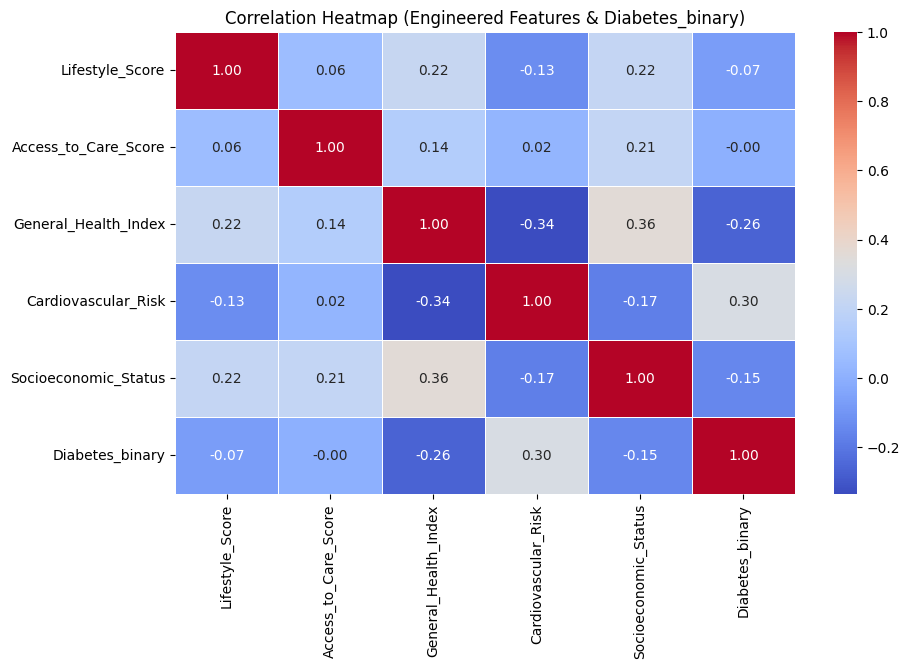

In [79]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_eng, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap (Engineered Features & Diabetes_binary)")
plt.show()

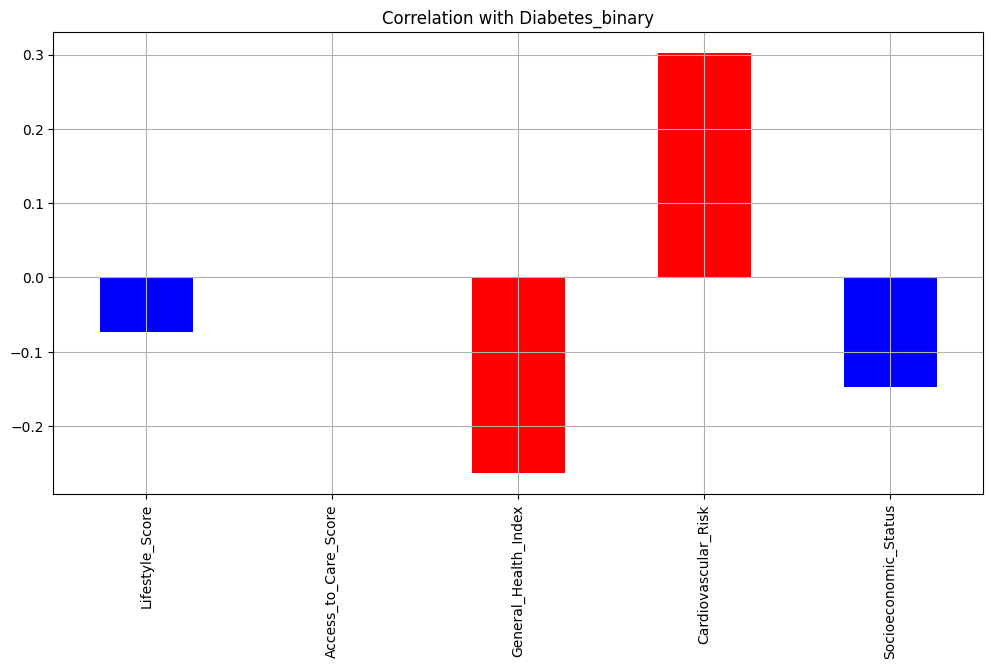

In [80]:
# Menghitung korelasi
corr_values = corr_eng["Diabetes_binary"].drop("Diabetes_binary")  # Hapus target agar tidak redundan

# Menentukan warna: warna berbeda untuk 2 nilai korelasi tertinggi dan terendah
sorted_corr = corr_values.abs().sort_values(ascending=False)
top2_indices = sorted_corr.head(2).index

colors = ["red" if col in top2_indices else "blue" for col in corr_values.index]

# Plot barplot korelasi
corr_values.plot(kind="bar", figsize=(12,6), color=colors, grid=True, title="Correlation with Diabetes_binary")

plt.show()

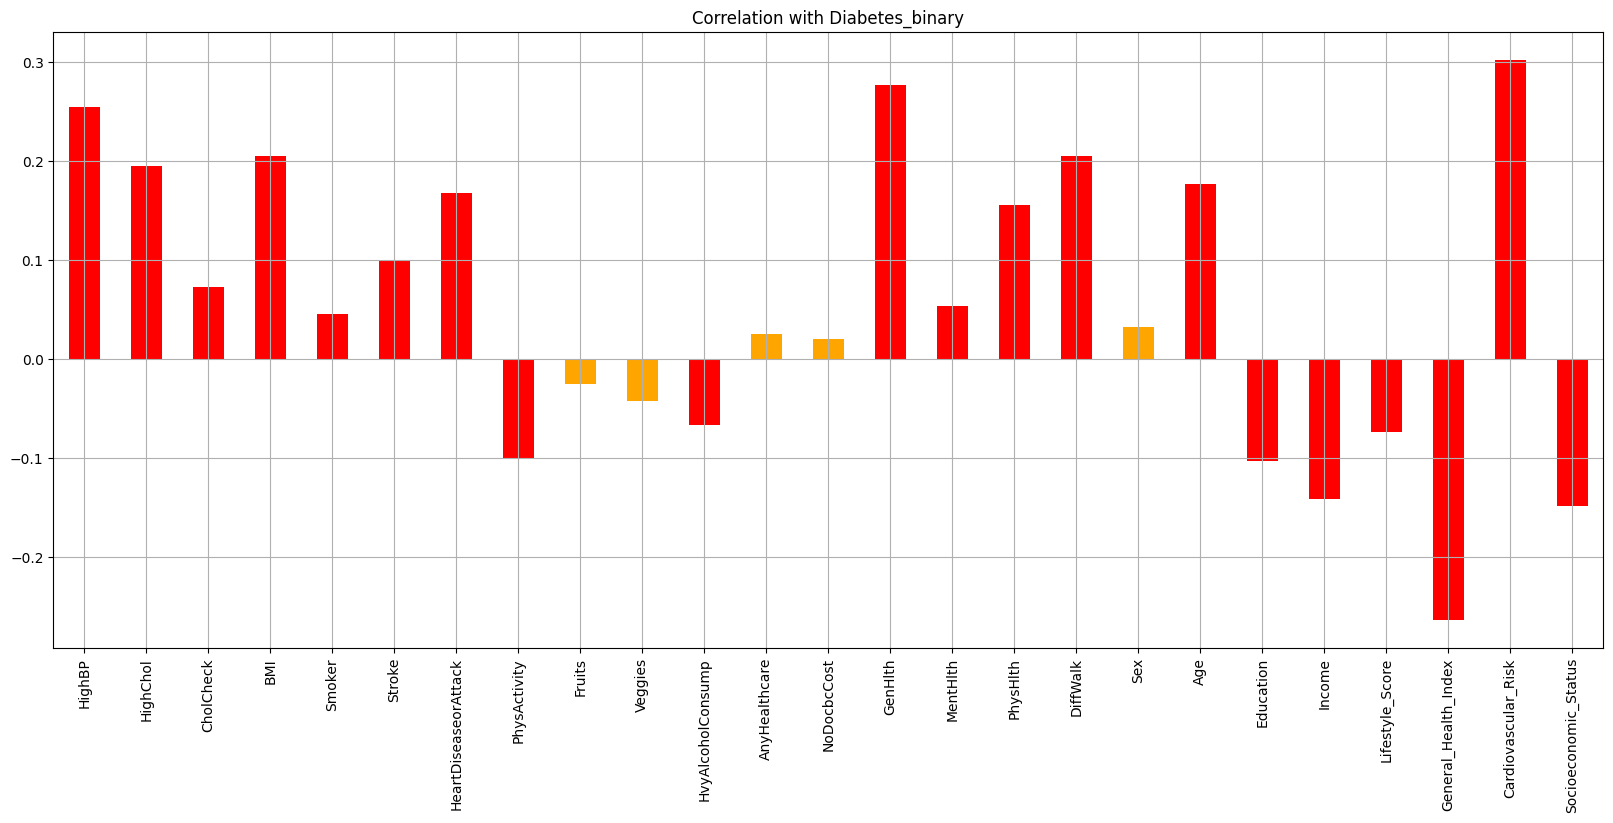

In [81]:

correlations =data.drop(['Diabetes_binary',"Access_to_Care_Score"] , axis=1).corrwith(data.Diabetes_binary)

# Get the indices of the 5 lowest absolute correlation values
lowest_5_indices = correlations.abs().nsmallest(5).index

# Assign colors: use 'red' for the lowest 5 and 'purple' for the rest
colors = ['orange' if col in lowest_5_indices else 'red' for col in correlations.index]

# Plot the correlation values
correlations.plot(kind='bar', grid=True, figsize=(20, 8), title="Correlation with Diabetes_binary", color=colors)

plt.show()

In [82]:
 # Check VIF to make sure no Multicollinearity
def calc_VIF(x):
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif = vif.sort_values(by="VIF", ascending=False)

    return vif

X = add_constant(data)

ds = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).sort_values(ascending=False)

print(ds)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


NoDocbcCost                  inf
HvyAlcoholConsump            inf
Cardiovascular_Risk          inf
General_Health_Index         inf
Access_to_Care_Score         inf
Lifestyle_Score              inf
Income                       inf
Education                    inf
PhysHlth                     inf
MentHlth                     inf
GenHlth                      inf
AnyHealthcare                inf
Socioeconomic_Status         inf
Veggies                      inf
Fruits                       inf
PhysActivity                 inf
HeartDiseaseorAttack         inf
Stroke                       inf
Smoker                       inf
HighChol                     inf
HighBP                       inf
DiffWalk                1.513943
Age                     1.359039
Diabetes_binary         1.182154
BMI                     1.141796
Sex                     1.076736
CholCheck               1.035970
const                   0.000000
dtype: float64


In [83]:
cols = ['HighBP', 'HighChol', 'CholCheck','Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

In [84]:
def create_plot_pivot(data2, x_column):
    _df_plot = data2.groupby([x_column, 'Diabetes_binary']).size().reset_index().pivot(columns='Diabetes_binary', index=x_column, values=0)
    return _df_plot

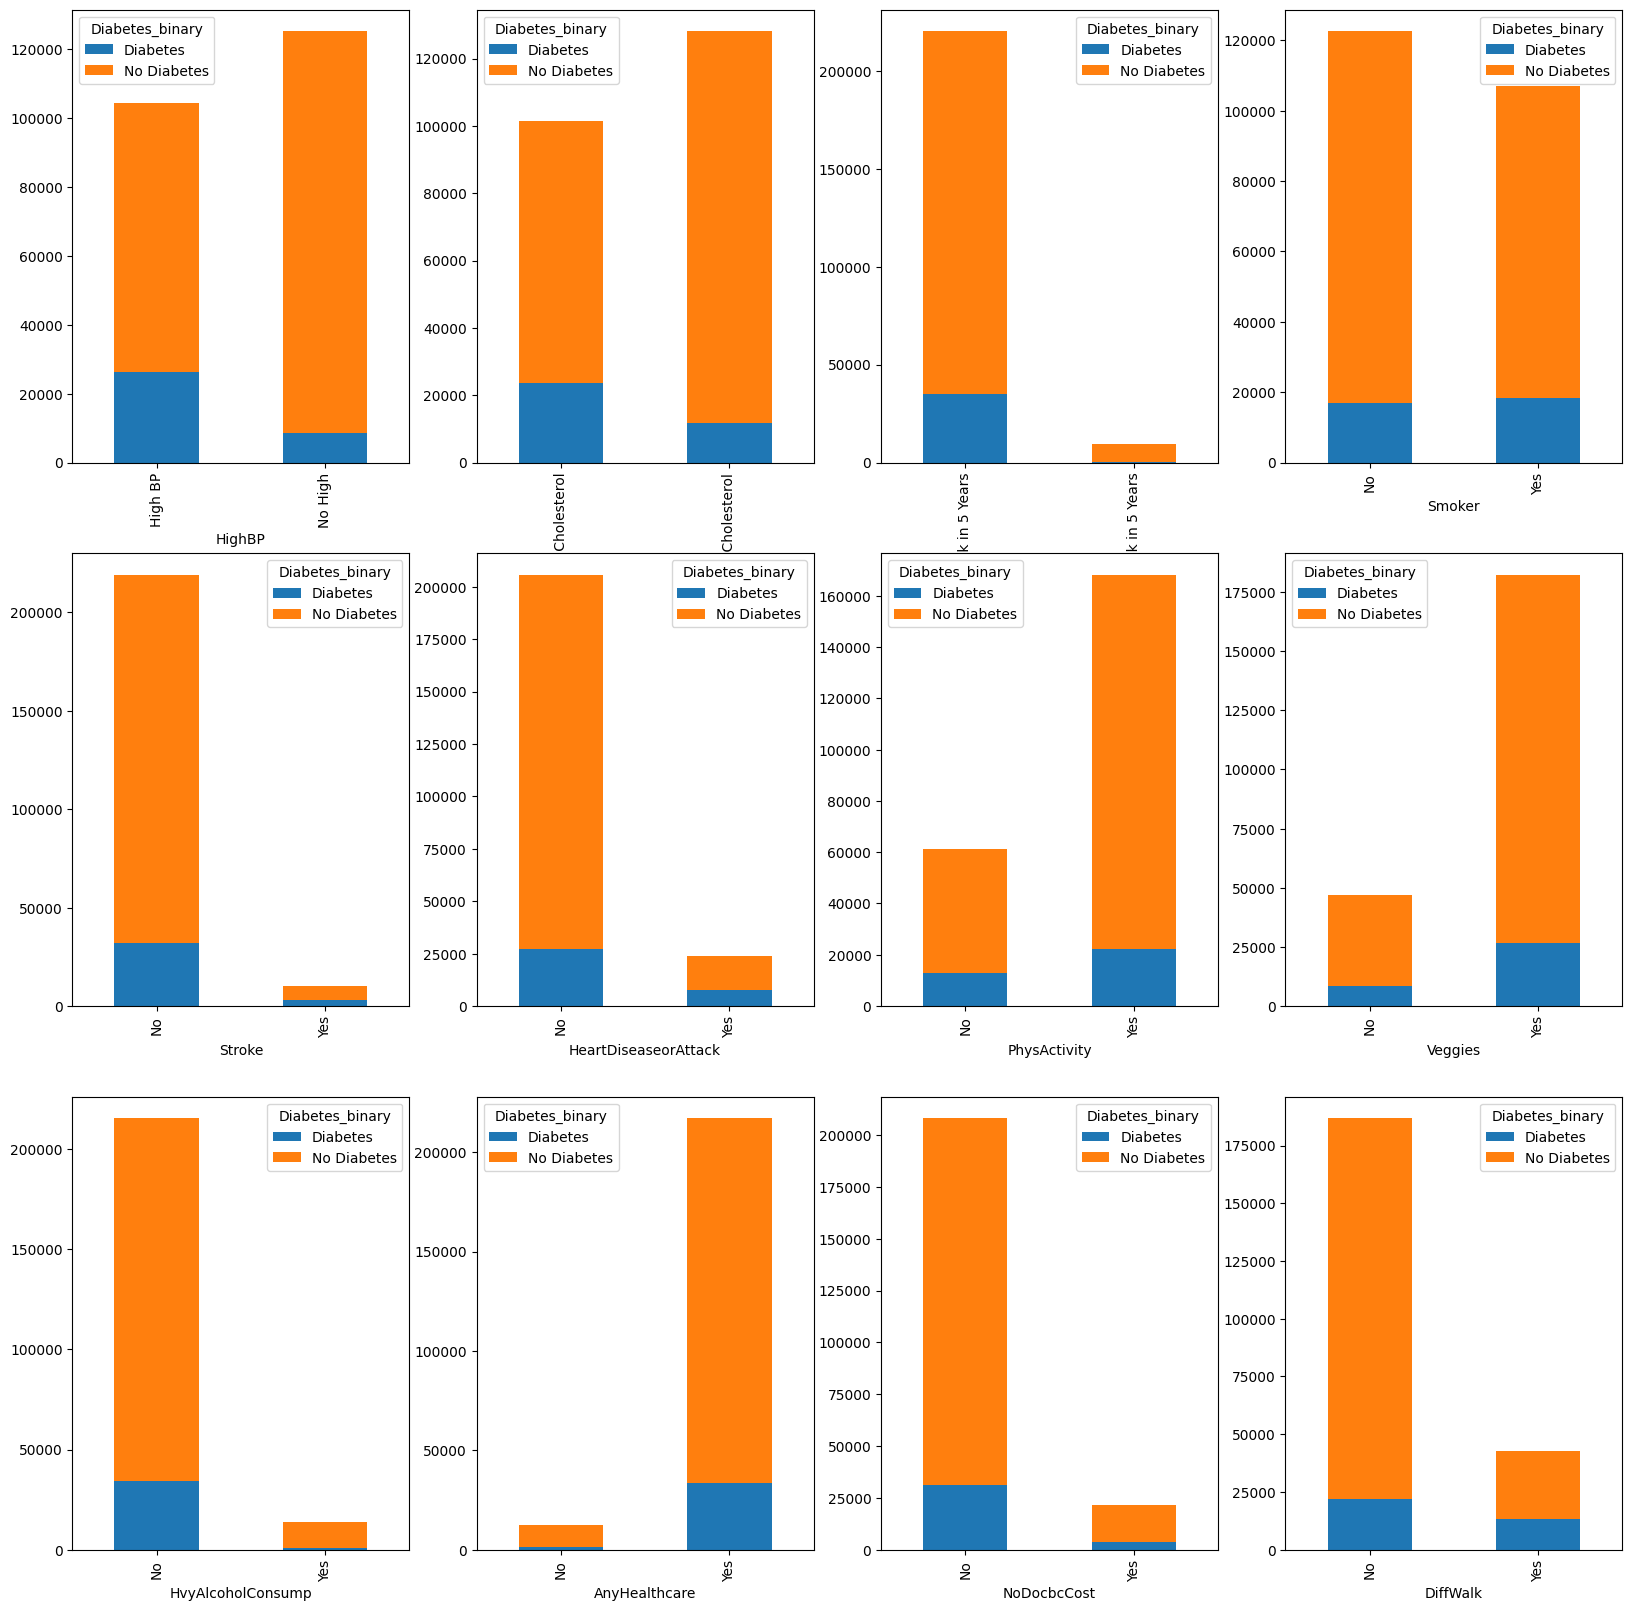

In [85]:
fig, ax = plt.subplots(3, 4, figsize=(20,20))
axe = ax.ravel()

c = len(cols)

for i in range(c):
    create_plot_pivot(data2, cols[i]).plot(kind='bar',stacked=True, ax=axe[i])
    axe[i].set_xlabel(cols[i])

fig.show()

In [86]:
data2["Diabetes_binary"].value_counts()

Diabetes_binary
No Diabetes    194377
Diabetes        35097
Name: count, dtype: int64

# View Target Value (Diabetes_binary)

<ipython-input-87-cf055dc51db3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data2, x='Diabetes_binary', palette=['skyblue', 'salmon'])


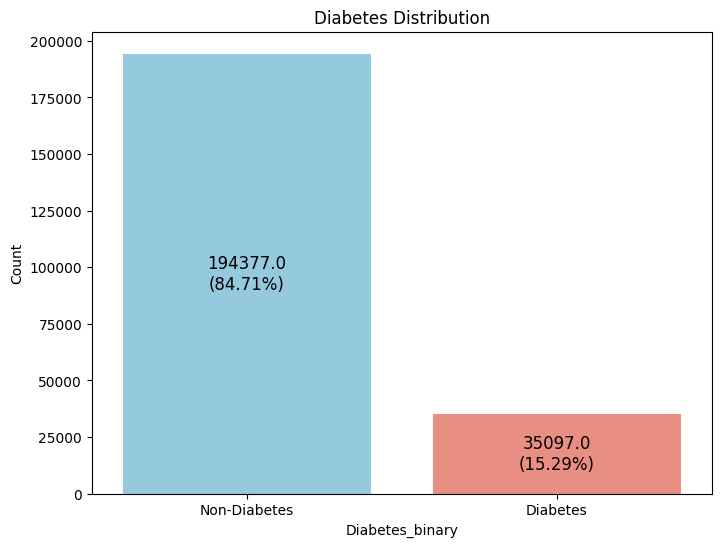

In [87]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(data=data2, x='Diabetes_binary', palette=['skyblue', 'salmon'])

total = len(data2)
for p in ax.patches:
    height = p.get_height()
    propor = height / total * 100
    ax.text(p.get_x() + p.get_width() / 2., height / 2,
            f'{height}\n({propor:.2f}%)',
            ha="center", va="center", fontsize=12, color='black')

# Mengatur label sumbu dan judul
plt.xticks([0, 1], ['Non-Diabetes', 'Diabetes'])
plt.ylabel('Count')
plt.title('Diabetes Distribution')

plt.show()

There is **more healthy people** than Diabetes

<ipython-input-88-7ab64c29ff1b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'Diabetes_binary', y = 'Age', data = data, palette='Set2')


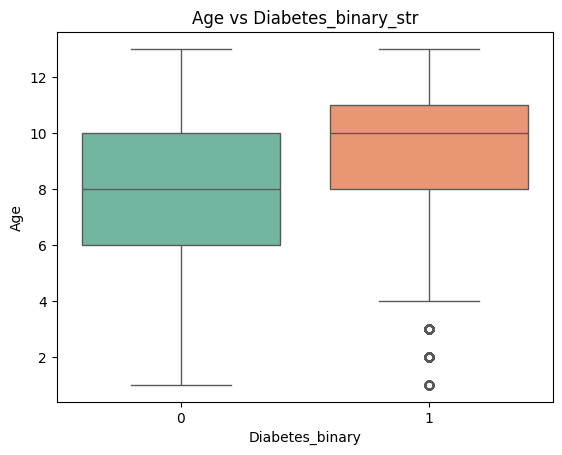

In [88]:
sns.boxplot(x = 'Diabetes_binary', y = 'Age', data = data, palette='Set2')
plt.title('Age vs Diabetes_binary_str')
plt.show()

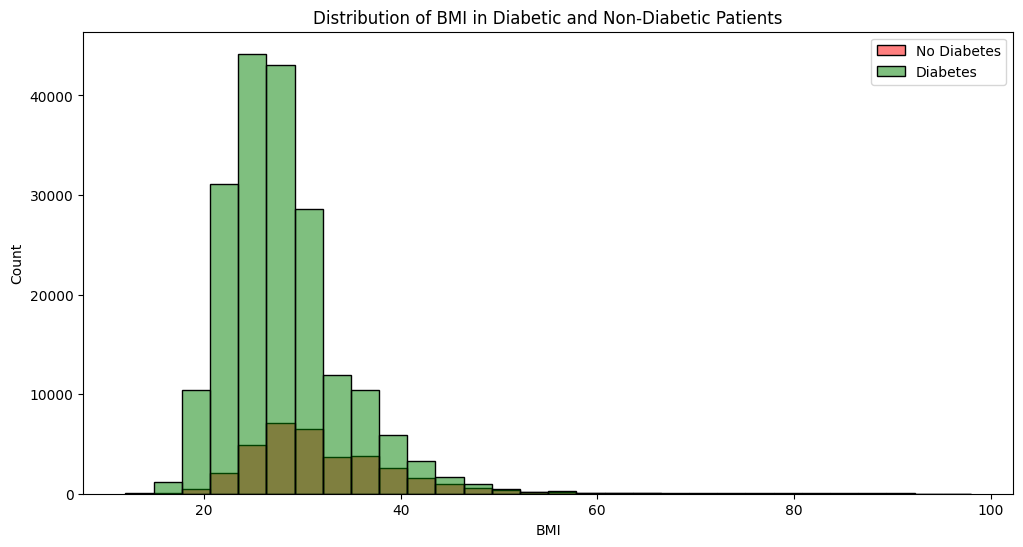

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Gunakan sns.histplot untuk variabel kontinu seperti BMI
sns.histplot(data=data, x="BMI", hue="Diabetes_binary", bins=30, palette = ["green", "red"])

plt.title("Distribution of BMI in Diabetic and Non-Diabetic Patients")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.legend(["No Diabetes", "Diabetes"])  # Pastikan label legend ditentukan dengan benar

plt.show()


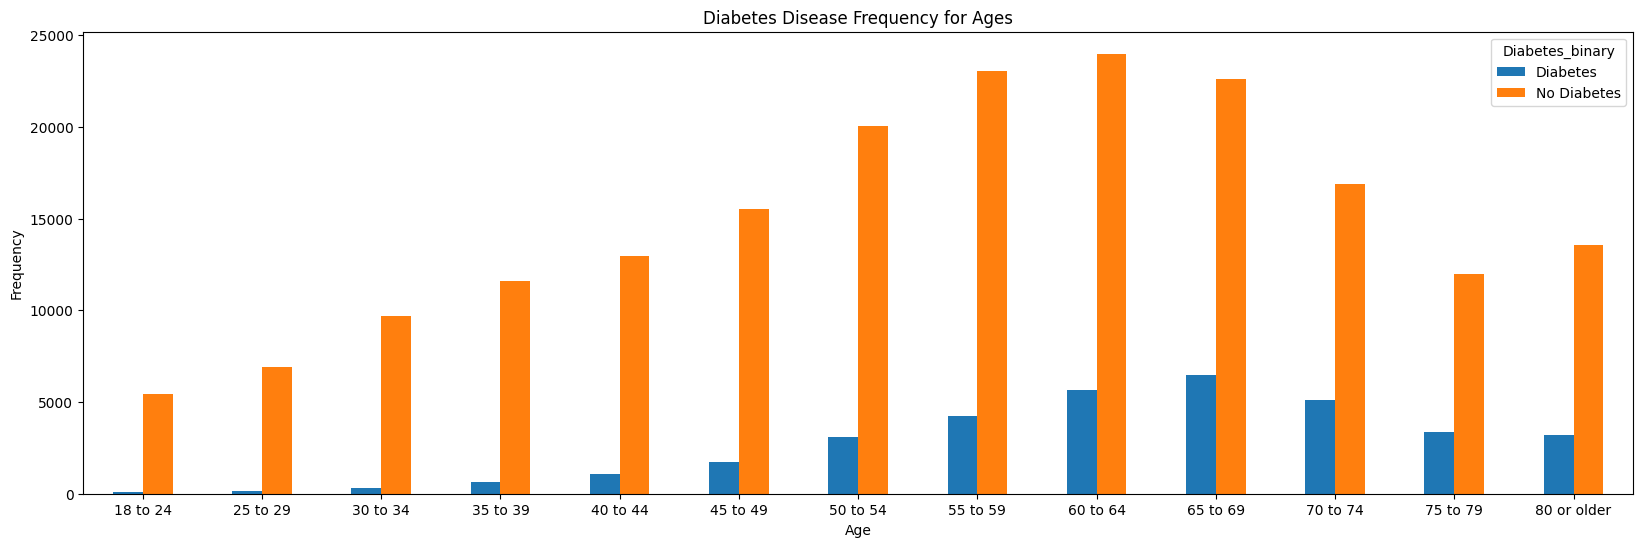

In [90]:
pd.crosstab(data2.Age,data2.Diabetes_binary).plot(kind="bar",figsize=(20,6))
plt.title('Diabetes Disease Frequency for Ages')
plt.xlabel('Age')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

as the age increases, the chances of diabetes also commonly increases. From above we can say, the median of the age of diabetic people is greater than that of non-diabetic people.


<ipython-input-91-7c3094e52ec9>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.Education[data.Diabetes_binary == 0], color="y", label="No Diabetic" )
<ipython-input-91-7c3094e52ec9>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.Education[data.Diabetes_binary == 1], color="m", labe

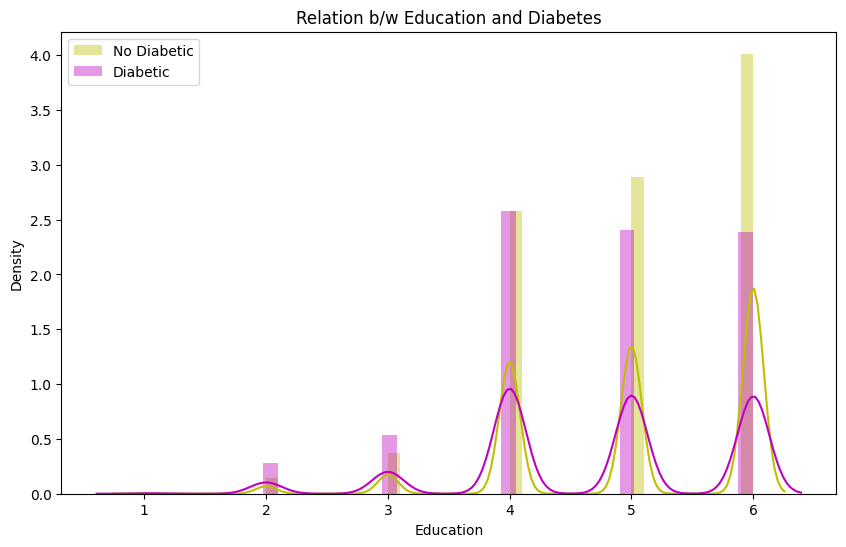

In [91]:
plt.figure(figsize=(10,6))


sns.distplot(data.Education[data.Diabetes_binary == 0], color="y", label="No Diabetic" )
sns.distplot(data.Education[data.Diabetes_binary == 1], color="m", label="Diabetic" )
plt.title("Relation b/w Education and Diabetes")

plt.legend()

most of people have high education and in the high level of education , the healthy people is more than others

Text(0.5, 1.0, 'Relation b/w Income and Diabetes')

<Figure size 2000x1000 with 0 Axes>

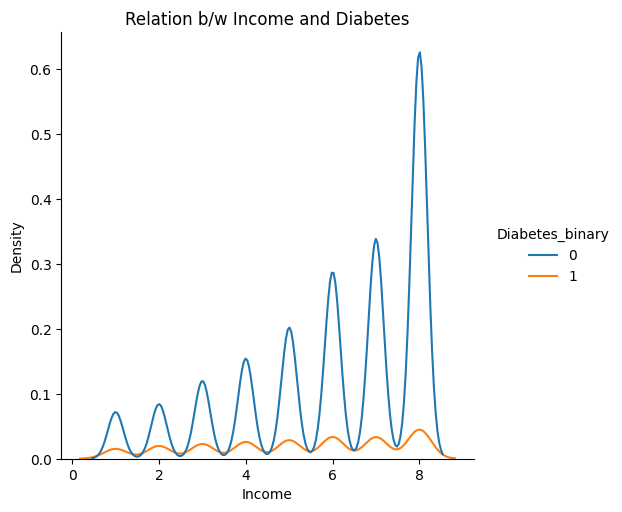

In [92]:
plt.figure(figsize=(20,10))

sns.displot(data=data, x="Income", hue="Diabetes_binary", kind="kde")
plt.title("Relation b/w Income and Diabetes")

most of people have high income and in the high level of income , the healthy people is more than others

people range between 24-33 BMI have more likely to have Diabetic.

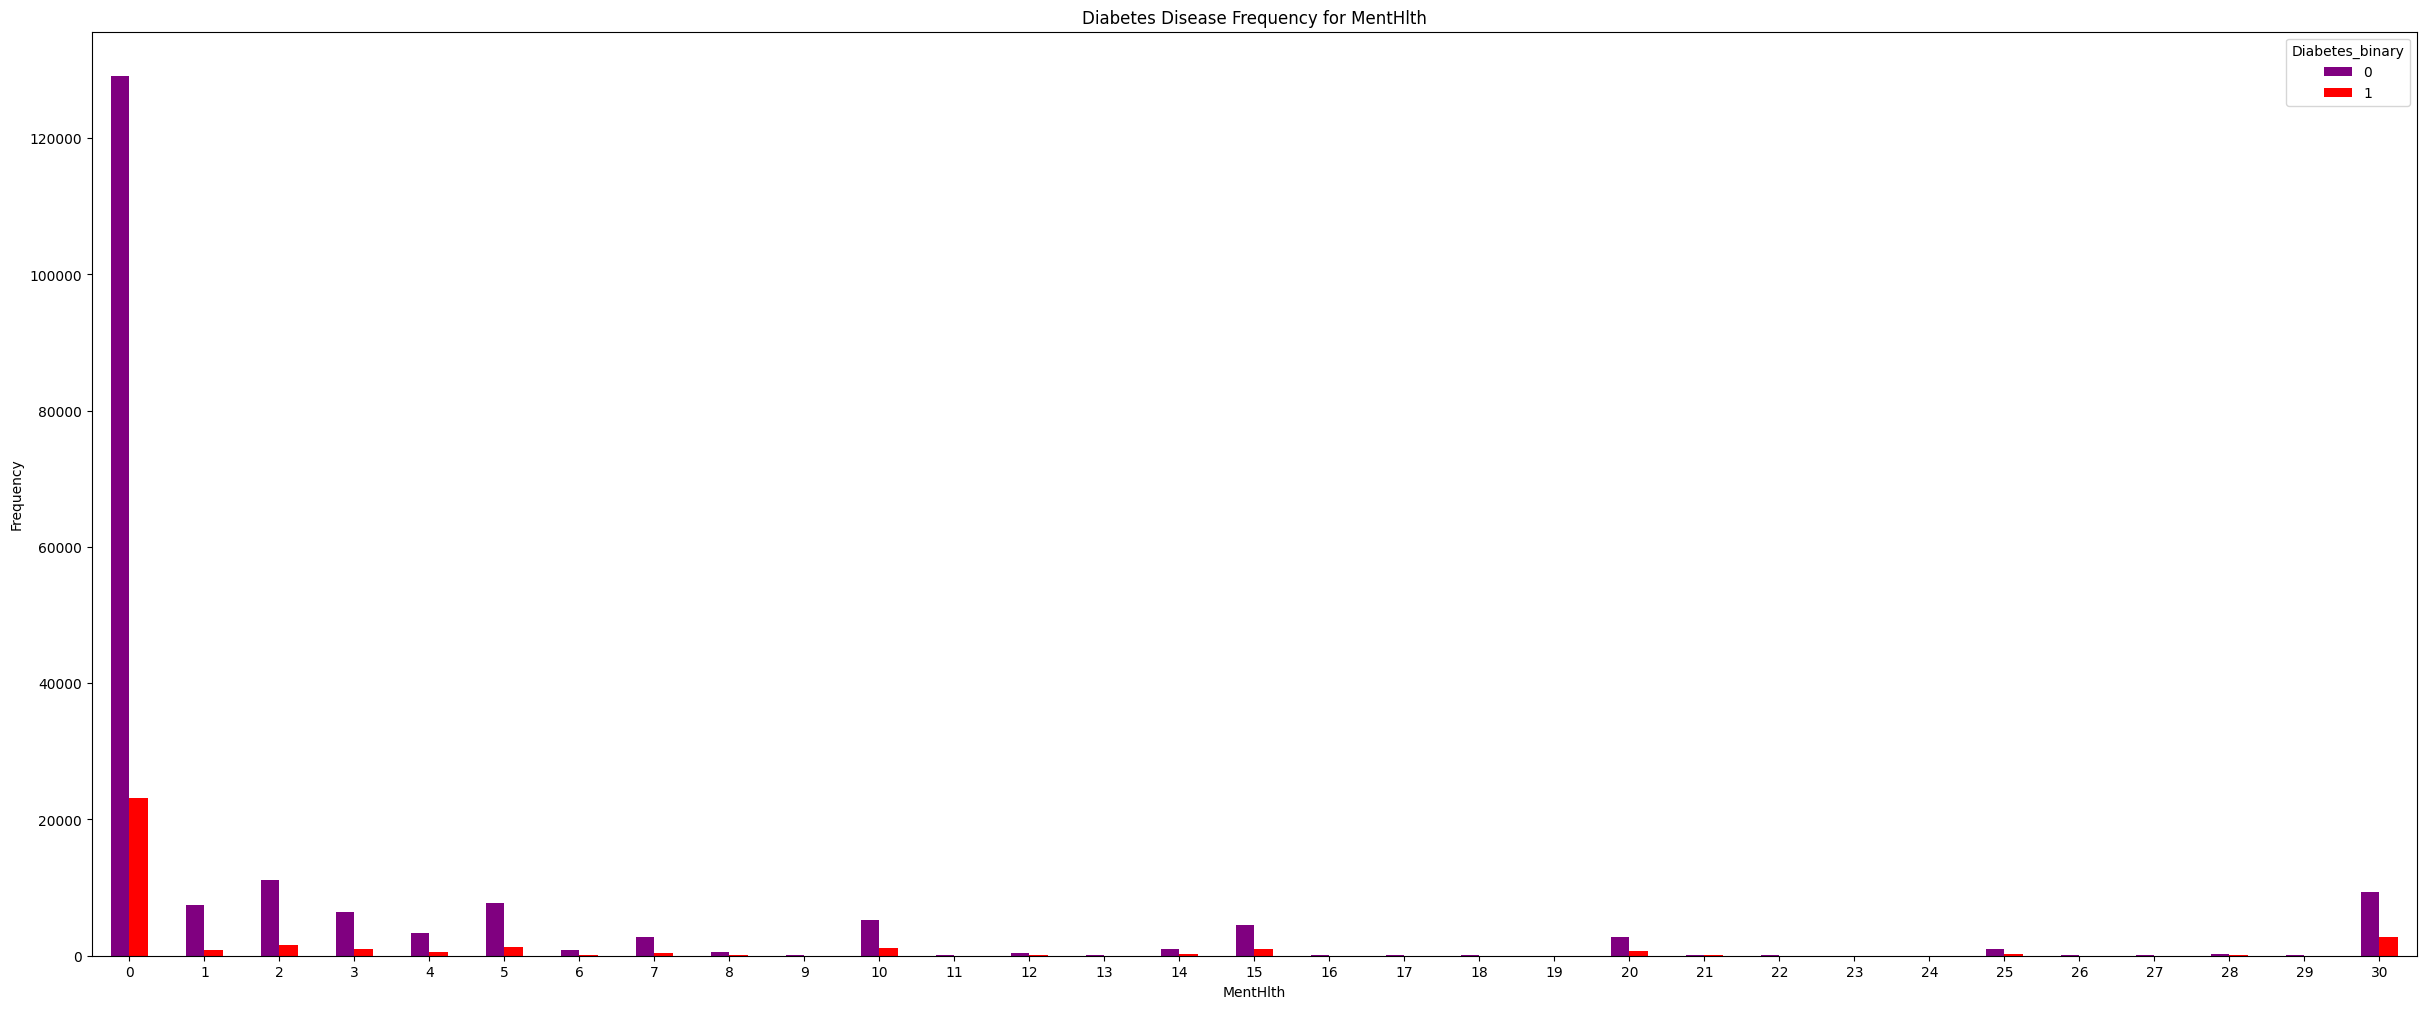

In [109]:
pd.crosstab(data.MentHlth,data.Diabetes_binary).plot(kind="bar",figsize=(30,12),color=['Purple', 'Red' ])
plt.title('Diabetes Disease Frequency for MentHlth')
plt.xlabel('MentHlth')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

People with 0-5 days of poor mental health have impact on Diabetic

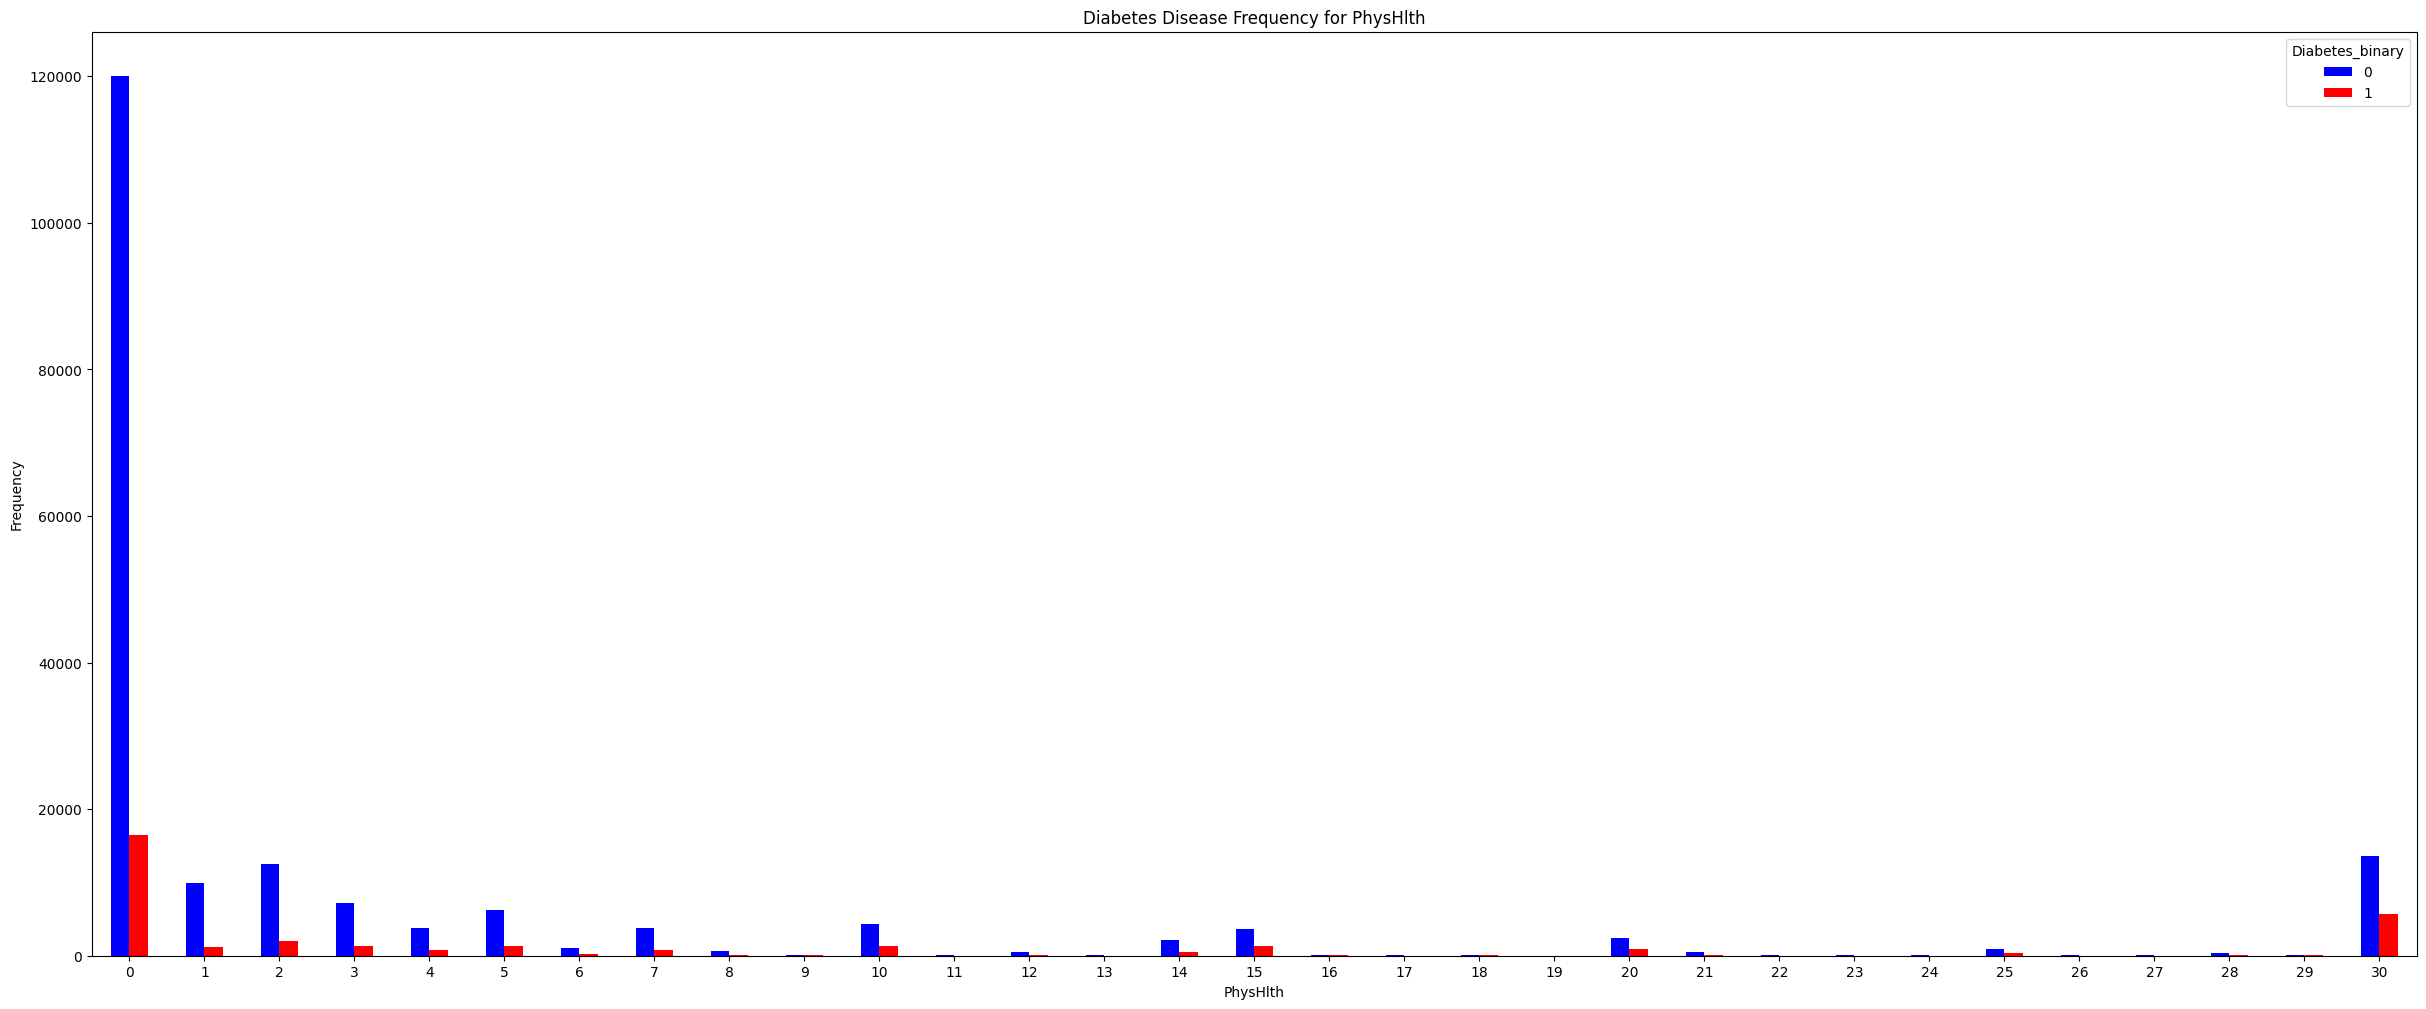

In [94]:
pd.crosstab(data.PhysHlth,data.Diabetes_binary).plot(kind="bar",figsize=(30,12),color=['Blue', 'Red' ])
plt.title('Diabetes Disease Frequency for PhysHlth')
plt.xlabel('PhysHlth')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

People with 0-5 days of poor physical health have impact on Diabetic

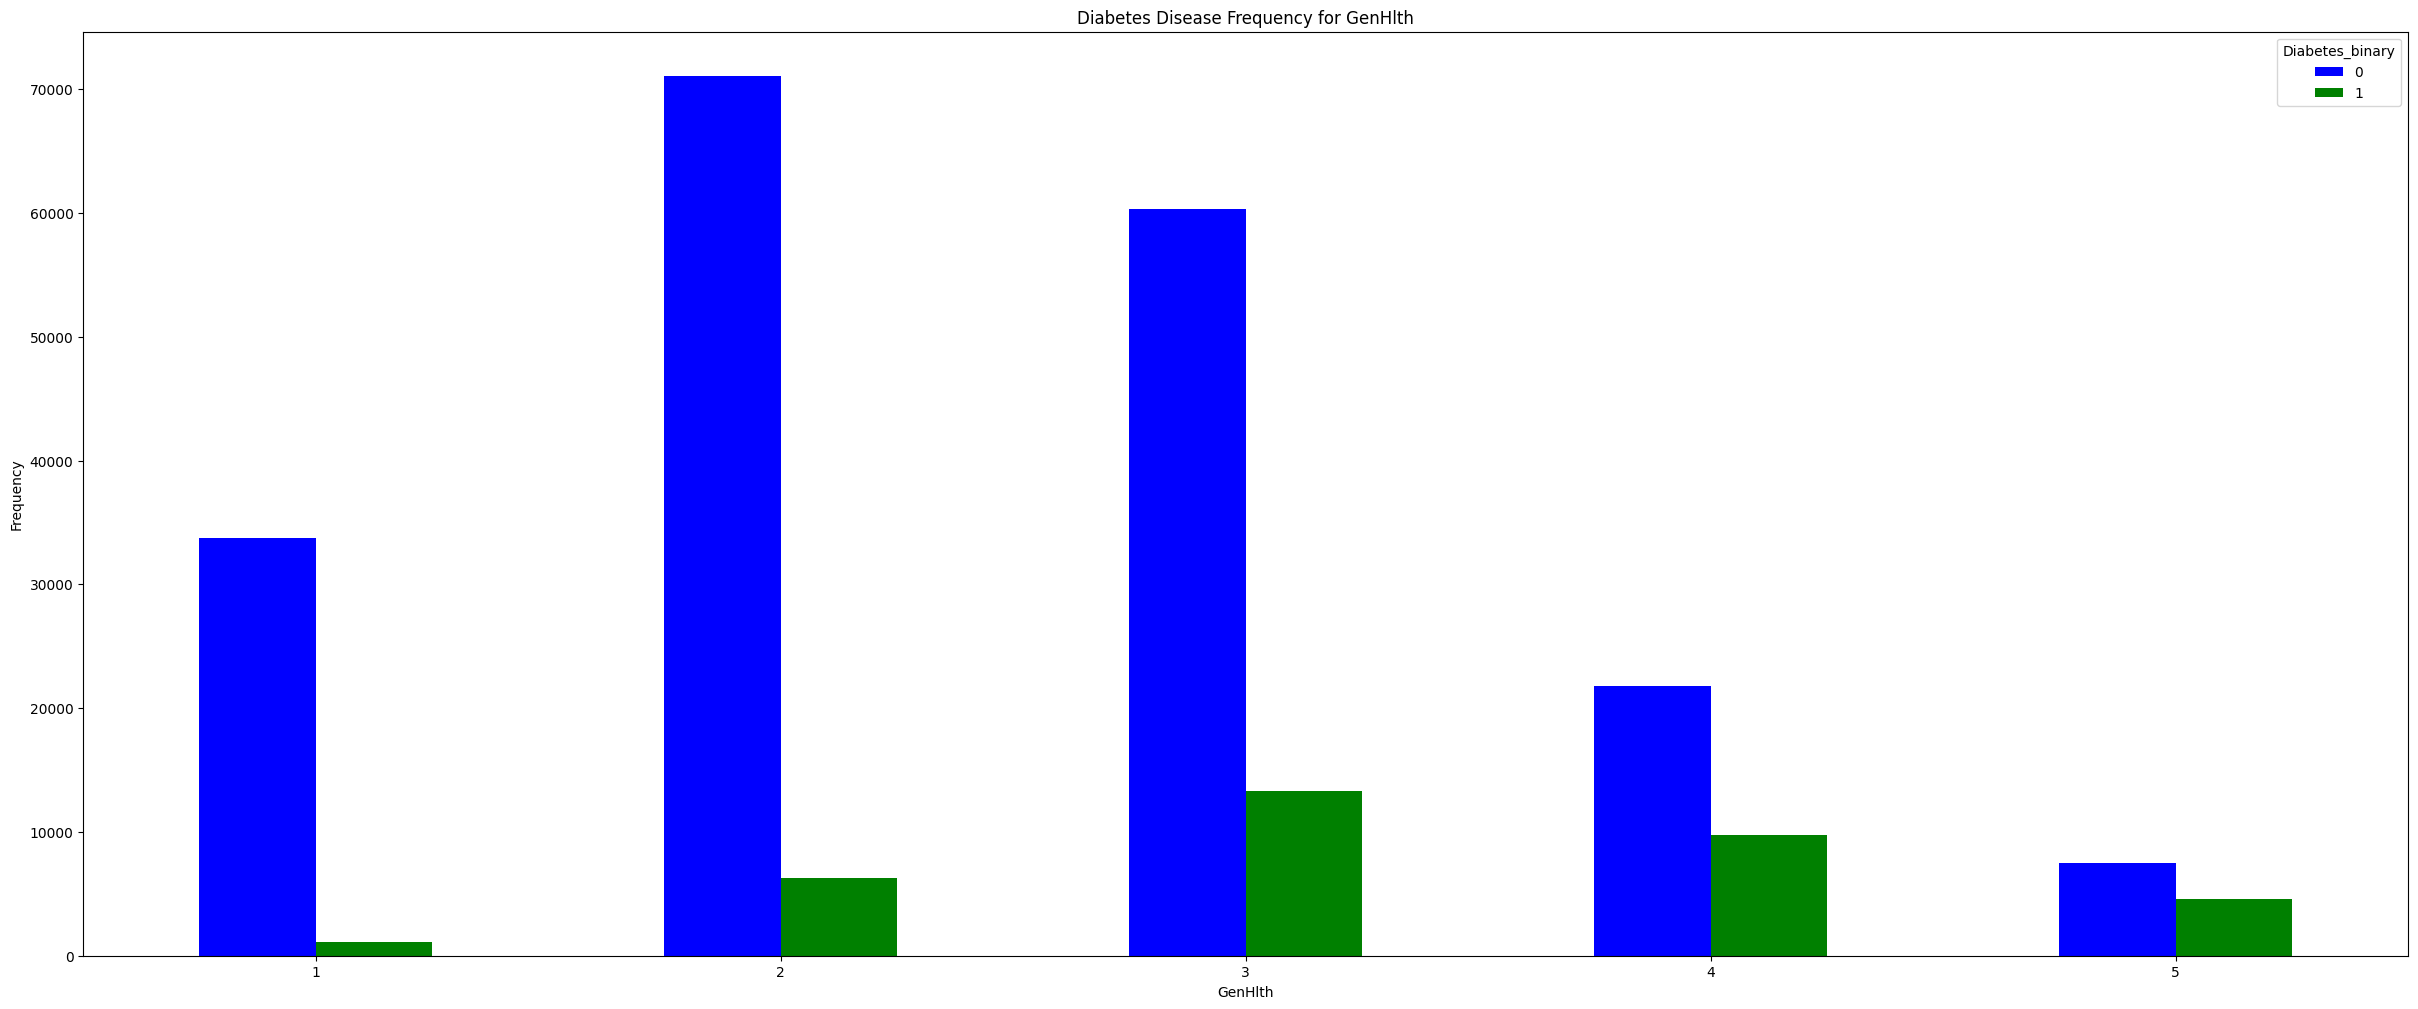

In [110]:
pd.crosstab(data.GenHlth,data.Diabetes_binary).plot(kind="bar",figsize=(30,12),color=['Blue', 'Green' ])
plt.title('Diabetes Disease Frequency for GenHlth')
plt.xlabel('GenHlth')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

not many peolpe have "5" and "4" of Self-reported general health ,but they have diabetes !!!

In [96]:

# FEATURE SELECTION

# Splitting into X,y for feature selection
target_col = 'Diabetes_binary'
X_fs = data.drop(columns=["Diabetes_binary","Age_str"], errors='ignore')
y_fs = data[target_col]

# ANOVA F-test (for numeric inputs vs. binary target)
sel_f_classif = SelectKBest(score_func=f_classif, k=10)
X_selected_f = sel_f_classif.fit_transform(X_fs, y_fs)
print("\nSelectKBest (f_classif) -> Shape of selected features:", X_selected_f.shape)

# Summaries
feature_scores_f = pd.DataFrame({
    'Feature': X_fs.columns,
    'F_Score': sel_f_classif.scores_
}).sort_values('F_Score', ascending=False)
print("\nTop Features by f_classif:")
print(feature_scores_f.head(15))



SelectKBest (f_classif) -> Shape of selected features: (229474, 10)

Top Features by f_classif:
                 Feature       F_Score
24   Cardiovascular_Risk  23064.819257
13               GenHlth  19061.436601
23  General_Health_Index  17057.912663
0                 HighBP  15868.017696
16              DiffWalk  10097.616798
3                    BMI  10075.425186
1               HighChol   9065.177413
18                   Age   7444.458687
6   HeartDiseaseorAttack   6682.140008
15              PhysHlth   5739.591424
25  Socioeconomic_Status   5122.499554
20                Income   4631.714144
19             Education   2445.440895
7           PhysActivity   2336.872150
5                 Stroke   2280.282576
SelectKBest (chi2) -> Shape of selected features: (229474, 10)

Top Features by Chi2:
                 Feature    Chi2_Score
15              PhysHlth  97988.761672
24   Cardiovascular_Risk  19146.628941
3                    BMI  15507.736174
14              MentHlth  11419.58475

In [96]:
# 7.2 Chi-square test (for categorical features vs. binary target)
sel_chi2 = SelectKBest(score_func=chi2, k=10)
X_selected_chi2 = sel_chi2.fit_transform(X_fs.abs(), y_fs)  # abs() ensures no negative.
print("SelectKBest (chi2) -> Shape of selected features:", X_selected_chi2.shape)

# Summaries
feature_scores_chi = pd.DataFrame({
    'Feature': X_fs.columns,
    'Chi2_Score': sel_chi2.scores_
}).sort_values('Chi2_Score', ascending=False)
print("\nTop Features by Chi2:")
print(feature_scores_chi.head(15))

In [97]:
X=data.drop("Diabetes_binary",axis=1)
Y=data["Diabetes_binary"]

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


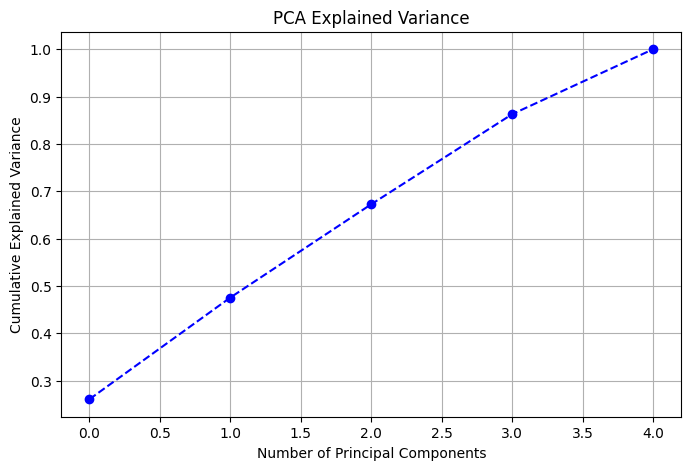

Optimal number of PCA components: 5

=== PCA Explained Variance Ratio ===
PC1: 26.07%, PC2: 21.48%


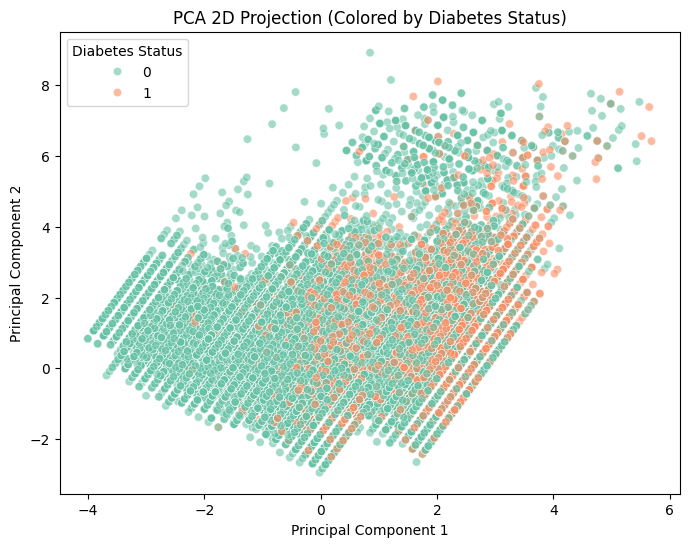

Silhouette Scores: {2: 0.4468222419903524, 3: 0.39178434225075964, 4: 0.38375567334705585, 5: 0.36719036895784196, 6: 0.347646458759417}
Optimal K from silhouette: 2


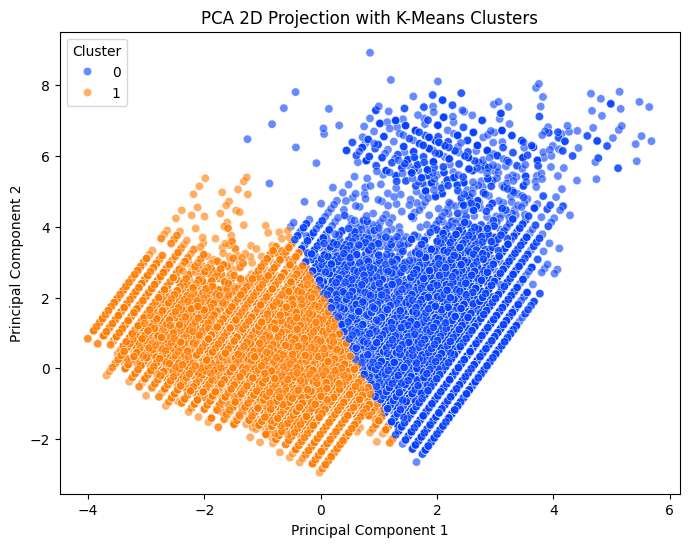

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# **1. Seleksi Fitur untuk PCA**
# Pilih hanya fitur numerik, tanpa 'Diabetes_binary' (target)
X = data.select_dtypes(include=[np.number]).drop(columns=['Diabetes_binary'], errors='ignore')

# Hapus fitur dengan variansi sangat rendah
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]  # Get selected feature names
X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)  # Keep original index

# Hapus fitur dengan multikolinearitas tinggi (VIF > 10)
vif_data = pd.DataFrame()
vif_data["Feature"] = selected_features  # Use selected features for VIF calculation
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

# Filter based on VIF using selected_features
features_to_keep = vif_data.loc[vif_data["VIF"] < 10, "Feature"] # Use selected_features for VIF filtering
X_final = X_selected[features_to_keep]

# **2. Standarisasi Data sebelum PCA (Wajib)**
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_final)

# **3. Tentukan jumlah komponen optimal dengan PCA**
pca_full = PCA()
pca_full.fit(X_pca_scaled)

# Plot Variance Explained untuk menentukan jumlah komponen optimal
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

# Pilih jumlah komponen yang mencakup 95% variansi data
n_components_optimal = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of PCA components: {n_components_optimal}")

# **4. Terapkan PCA dengan 2 komponen untuk visualisasi**
pca_model = PCA(n_components=2, random_state=42)
X_pca_2D = pca_model.fit_transform(X_pca_scaled)
data['PC1'] = X_pca_2D[:, 0]
data['PC2'] = X_pca_2D[:, 1]

expl_var = pca_model.explained_variance_ratio_
print("\n=== PCA Explained Variance Ratio ===")
print(f"PC1: {expl_var[0]*100:.2f}%, PC2: {expl_var[1]*100:.2f}%")

# **5. Visualisasi PCA dalam 2D**
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue=data['Diabetes_binary'].astype(str), data=data, palette='Set2', alpha=0.6)
plt.title("PCA 2D Projection (Colored by Diabetes Status)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Diabetes Status")
plt.show()

# **6. K-Means Clustering pada PCA Output**
sil_scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca_2D)
    sil = silhouette_score(X_pca_2D, labels)
    sil_scores[k] = sil

best_k = max(sil_scores, key=sil_scores.get)
print("Silhouette Scores:", sil_scores)
print("Optimal K from silhouette:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca_2D)
data['Cluster'] = cluster_labels

# **7. Visualisasi Hasil Clustering setelah PCA**
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=data, palette='bright', alpha=0.6)
plt.title("PCA 2D Projection with K-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [104]:
# REGRESSION

# Predict BMI (continuous) from other features.
from sklearn.impute import SimpleImputer # <--- Added this line
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
)
from mlxtend.plotting import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector






In [105]:
target_reg = 'BMI'
features_reg_all = [
    'HighBP','HighChol','CholCheck','Smoker','Stroke','HeartDiseaseorAttack','PhysActivity',
    'Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','GenHlth','MentHlth',
    'PhysHlth','DiffWalk','Sex','Age','Education','Income'
]

X_reg = data[features_reg].copy()
y_reg = data[target_reg].copy()

# Impute / scale
imp_reg = SimpleImputer(strategy='mean')
X_reg_imp = imp_reg.fit_transform(X_reg)
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg_imp)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg_scaled, y_reg, test_size=0.3, random_state=42
)

In [ ]:
# --- Exhaustive Feature Selection (EFS) for Linear Regression  ---
linreg = LinearRegression()
efs = ExhaustiveFeatureSelector(
    linreg,
    min_features=3,
    max_features=8,
    scoring='r2',
    cv=3
)
efs.fit(X_reg_scaled, y_reg)
print("\n=== Exhaustive Feature Selector (Regression) ===")
print(f"Best R2: {efs.best_score_:.3f}")
best_idx = efs.best_idx_
best_features_reg = [features_reg[i] for i in best_idx]
print("Best feature subset:", best_features_reg)


In [ ]:
def evaluate_regression(model, X_test, y_test, name=""):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = math.sqrt(mse)
    r2 = model.score(X_test, y_test)
    print(f"{name}: MAE={mae:.3f}, MSE={mse:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

# Train multiple regression models:
models_reg = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'DecisionTree': DecisionTreeRegressor(max_depth=8, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
}

print("\n=== Regression Model Comparison (Predicting BMI) ===")
for name, mdl in models_reg.items():
    mdl.fit(X_train_r, y_train_r)
    evaluate_regression(mdl, X_test_r, y_test_r, name)

In [ ]:
# CLASSIFICATION

target_clf = 'Diabetes_binary'
features_clf_all = [
    'HighBP','HighChol','CholCheck','BMI','Smoker','Stroke','HeartDiseaseorAttack',
    'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost',
    'GenHlth','MentHlth','PhysHlth','DiffWalk','Sex','Age','Education','Income'
]

X_clf = data[features_clf_all].copy()
y_clf = data[target_clf].copy()


# Data split
X_clf_imp = imp_reg.fit_transform(X_clf)  # re-use or define new imputer
scaler_clf = StandardScaler()
X_clf_scaled = scaler_clf.fit_transform(X_clf_imp)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf_scaled, y_clf, test_size=0.3, stratify=y_clf, random_state=42
)

# Show class distribution
print("\nClass Distribution in Original Data:")
print(y_clf.value_counts(normalize=True))

#  Over-sampling with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_c, y_train_c)
print("\nAfter SMOTE, training class distribution:")
print(pd.Series(y_train_sm).value_counts(normalize=True))



In [ ]:
# Model Training & Comparison
def evaluate_classifier(model, X_test, y_test, name=""):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    print(f"{name}: Accuracy={acc:.3f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, preds))
    return acc

models_clf = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=12, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=6),
    'RandomForest': RandomForestClassifier(max_depth=12, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', C=1.0, random_state=42, probability=True),
    'XGBoost': XGBClassifier(eval_metric='error', learning_rate=0.1, random_state=42)
}

print("\n=== Classification Model Comparison (Predicting Diabetes) ===")
clf_performance = {}
for name, clf_model in models_clf.items():
    # Train on SMOTE sample
    clf_model.fit(X_train_sm, y_train_sm)
    acc = evaluate_classifier(clf_model, X_test_c, y_test_c, name)
    clf_performance[name] = acc


In [ ]:
# Hyperparameter Tuning (for RandomForest + XGBoost)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12]
}
gs_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=3
)
gs_rf.fit(X_train_sm, y_train_sm)
best_rf = gs_rf.best_estimator_
print("\nBest RandomForest params:", gs_rf.best_params_)
best_acc_rf = evaluate_classifier(best_rf, X_test_c, y_test_c, "Optimized RF")

param_grid_xgb = {
    'learning_rate':[0.01, 0.1],
    'subsample':[0.8, 1.0]
}
gs_xgb = GridSearchCV(
    XGBClassifier(eval_metric='error', random_state=42),
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=3
)
gs_xgb.fit(X_train_sm, y_train_sm)
best_xgb = gs_xgb.best_estimator_
print("Best XGBoost params:", gs_xgb.best_params_)
best_acc_xgb = evaluate_classifier(best_xgb, X_test_c, y_test_c, "Optimized XGB")


In [ ]:
"""
INSIGHTS:

1) PCA & Clustering:
   - Clusters with high PC1 or PC2 may indicate populations with specific risk profiles
     (e.g., older, more comorbidities). Public health interventions can target these segments.

2) Regression for BMI:
   - Understanding which factors (GenHlth, MentHlth, Age, etc.) most predict BMI
     can guide weight-management programs. For instance, older individuals with
     lower general health may need tailored nutrition and exercise plans.

3) Classification for Diabetes:
   - Models like RandomForest or XGBoost can robustly predict diabetes status
     (especially after addressing imbalance).
   - Clinically, this aids in early risk detection and resource prioritization.

4) Feature Importance & Multi-Model Approach:
   - Combining domain knowledge, VIF checks, feature selection (Chi2/ANOVA/EFS),
     and model interpretability (e.g., SHAP) can refine the set of relevant risk factors.
   - This fosters targeted interventions: lifestyle improvements for high-risk
     or better screening protocols for certain demographics.

5) Societal & Business Impact:
   - Reducing diabetes prevalence lowers healthcare costs, improves population
     health, and can direct social policies (e.g., subsidies for healthy food,
     structured exercise programs, etc.).
   - Employers and insurance companies can adopt these models to identify at-risk
     individuals for proactive support.

Overall, advanced ML combined with domain-specific feature engineering
can yield impactful solutions for diabetes prevention and management.
"""